In [2]:
import numpy as np
from libow8 import sensor_net
import matplotlib.pyplot as plt
import owutils as ut
from designs import designs, align_receiver_to_transmitter
from panel_ow import Panel
from pyswarms.single.global_best import GlobalBestPSO

In [3]:
import copy
import numpy as np


h_ww = None
r_sens = None
n_particles = 40

# ----------------------
# Parameters (top-level)
# ----------------------
KEY = 'A'
params_d = designs[KEY]
params_amb = designs['A'].copy()
params_amb['r_master'] = params_d['r_lights']
params_amb['PT_master'] = params_d['PT_lights']


h_ww = None
h_amb = None

# ----------------------
# Simulation function
# ----------------------
def sensor_ar(x, params_d=None, params_amb=None):

    global h_ww, h_amb, r_sens, nS_sens, n_particles

   
    x = np.atleast_2d(x)
    if x.shape[1] != 1:
        raise ValueError("sensor_ar expects x with shape (n_particles, 1) where column is area")

    area = x[:, 0]         

    r_vec = np.asarray(r_sens).reshape(1, -1)              
    r_sensor = np.repeat(r_vec, repeats=n_particles, axis=0)  

    
    nS_vec = np.asarray(nS_sens).reshape(1, -1)           
    nR = np.repeat(nS_vec, repeats=n_particles, axis=0)  

    pd_base = copy.deepcopy(params_d)
    pa_base = copy.deepcopy(params_amb)

    pa_base['r_sensor'] = r_sensor
    pa_base['nR_sensor'] = nR
    pa_base['A_sensor'] = area
    pa_base['nS_sensor'] = np.repeat(nS_vec, repeats=n_particles, axis=0)

    l_amb = sensor_net(**pa_base)
    l_amb.calch(h_ww=h_amb)
    l_amb.light_sim()
    h_amb = l_amb.h_ww

    pd_base['r_sensor'] = r_sensor
    pd_base['nR_sensor'] = nR
    pd_base['A_sensor'] = area
    pd_base['nS_sensor'] = np.repeat(nS_vec, repeats=n_particles, axis=0)

    l = sensor_net(**pd_base)
    l.calch(h_ww=h_ww)
    l.light_sim()
    h_ww = l.h_ww
    l.calc_noise()
    l.calc_rq()

    # ----------------------
    # Compute received powers / irradiances
    # ----------------------
    p_all = (
        np.sum(np.sum(l_amb.Pin_sm_diff, axis=0), axis=1)
        + np.sum(l_amb.Pin_sm, axis=0)
        + l_amb.Pin_sa
        + 0.5 * l.Pin_sm_tot.flatten()
    )   # shape: (n_particles,)

    p_no_sun = (
        np.sum(np.sum(l_amb.Pin_sm_diff, axis=0), axis=1)
        + np.sum(l_amb.Pin_sm, axis=0)
    )

    p_los = np.sum(l_amb.Pin_sm, axis=0)
    p_diff = np.sum(np.sum(l_amb.Pin_sm_diff, axis=0), axis=1)
    p_amb = l_amb.Pin_sa


    G_all = p_all / l_amb.A_sensor
    G_los = p_los / l_amb.A_sensor
    G_ac = (l.Pin_sm_tot.flatten()) / l_amb.A_sensor
    G_no_sun = p_no_sun / l_amb.A_sensor

 
    panels = []
    n_elems = p_all.shape[0]
    pmax = np.zeros(n_elems)
    ind = np.zeros(n_elems, dtype=int)
    bw = np.zeros(n_elems)
    snr = np.zeros(n_elems)
    signal = np.zeros(n_elems)
    noise = np.zeros(n_elems)
    snr_dB = np.zeros(n_elems)
    v = np.zeros(n_elems)
    C = np.zeros(n_elems)
    req = np.zeros(n_elems)
    rx = np.zeros(n_elems)

    freq = np.linspace(100, 20000, 400)

    for ii in range(n_elems):
        panels.append(
            Panel(
                l_amb.A_sensor[ii] * 1e4,  # area in cm^2 if your Panel expects that
                rs=1, rsh=1000, n=1.6,
                voc=0.64, isc=35e-3,
                G=G_all[ii], Gac=G_ac[ii]
            )
        )
        try:
            panels[ii].run(False)


            pmax[ii] = panels[ii].Pmax
            ind[ii] = int(panels[ii].ind)

 
            panels[ii].calc_capacitance()
            panels[ii].set_circuit(Rc=10, Lo=10, Co=220e-6)
            panels[ii].find_bw()

            idx = int(ind[ii])
            if idx < 0 or idx >= len(panels[ii].BW):

                idx = np.clip(idx, 0, len(panels[ii].BW) - 1)
            bw[ii] = panels[ii].BW[idx]


            panels[ii].tf(freq)
            panels[ii].thermal_noise()
            panels[ii].all_thermal_noise(freq)
            panels[ii].shot_noise(freq)
            panels[ii].vp2p(freq)

 
            signal[ii] = panels[ii].vac[idx]
            th_val = panels[ii].th_noise[idx] if idx < len(panels[ii].th_noise) else panels[ii].th_noise[-1]
            sh_val = panels[ii].sh_noise[idx] if idx < len(panels[ii].sh_noise) else panels[ii].sh_noise[-1]
            noise[ii] = 4 * (th_val + sh_val)

            if noise[ii] <= 0 or not np.isfinite(noise[ii]):
                snr[ii] = 0.0
                snr_dB[ii] = -1e3
            else:
                snr[ii] = (signal[ii] ** 2) / noise[ii]
                snr_db_val = 10.0 * np.log10(snr[ii]) if snr[ii] > 0 and np.isfinite(snr[ii]) else -1e3
                snr_dB[ii] = snr_db_val

            v[ii] = panels[ii].V[idx] if idx < len(panels[ii].V) else panels[ii].V[-1]
            C[ii] = panels[ii].C[idx] if idx < len(panels[ii].C) else panels[ii].C[-1]
            req[ii] = panels[ii].req[idx] if idx < len(panels[ii].req) else panels[ii].req[-1]
            rx = panels[ii].rx

        except Exception as e:
            pmax[ii] = 0.0
            snr_dB[ii] = -1e3
            bw[ii] = 0.0



    try:
        l.calc_tbattery(br=np.floor(bw) * 0.4)
    except Exception:
        pass

    e_day = pmax * 3600.0 * 8.0 * 0.8     
    V = 3.3  # Volt
    cycle_p = np.array([c.calc_cycle_consumption() for c in l.cycles]) * V
    day_s = 3600.0 * 24.0
    cycles_day = day_s / l.Tcycle
    e_day_c = cycles_day * cycle_p

    # ----------------------
    # Penalties / constraints
    # ----------------------
    penalty = np.zeros_like(e_day_c)

    PEN = 1e6
    penalty[snr_dB < 8.5] = PEN
    penalty[e_day < e_day_c] = PEN

    # ----------------------
    # Final fitness = area (m^2) + penalties
    # ----------------------
    fitness = area + penalty

    # ensure return is shape (n_particles,)
    fitness = np.asarray(fitness).reshape(-1)

    return fitness


# ----------------------
# Fitness wrapper for PSO
# ----------------------
def fit_function(x):
    """
    Wrapper passed to PSO.
    Input x: normalized swarm positions in [0,1] of shape (n_particles, 1).
    Column meaning: area normalized.
    Denormalization: area in m^2 between [A_min, A_max].
    """
    A_min = 0.0001
    A_max = 0.1

    x = np.atleast_2d(x)
    if x.shape[1] != 1:
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        else:
            raise ValueError("fit_function expects input x with one column (area)")

    area = A_min + x[:, 0] * (A_max - A_min)
    x_denorm = area.reshape(-1, 1)

    f = sensor_ar(x_denorm, params_d=params_d, params_amb=params_amb)

    g = np.array(f).reshape(x.shape[0])
    return g


# ----------------------
# Main optimization loop
# ----------------------
r_sen = designs[KEY]['r_sensor']
nS_sen = np.round(align_receiver_to_transmitter(r_sen, np.array([5, 5, 3])), 2)
N = r_sen.shape[0]

pos_l = [0] * N   # Sensor positions
pow_l = [0] * N   # Optical powers (best cost)
op_l = [0] * N    # Optimal areas

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.7}

lb = np.zeros(1)
ub = np.ones(1)

all_cost_histories = []

for i in range(N):
    r_sens = r_sen[i]        
    nS_sens = nS_sen[i]       
    print(f"Optimizing sensor {i+1} of {N} at position {r_sens}")

    optimizer = GlobalBestPSO(
        n_particles=n_particles,
        dimensions=1,
        options=options,
        bounds=(lb, ub)
    )

    best_cost, best_pos = optimizer.optimize(fit_function, iters=50)

    A_min = 0.0001
    A_max = 0.1
    best_area = A_min + best_pos[0] * (A_max - A_min)

    pos_l[i] = r_sens
    op_l[i] = [best_area]
    pow_l[i] = best_cost
    all_cost_histories.append(optimizer.cost_history)

# ----------------------
# Results output
# ----------------------
print("\nOptimization complete!")
for i in range(N):
    print(f"Sensor {i+1}: Position={pos_l[i]}, BestCost={pow_l[i]:.6f}, Area={op_l[i][0]:.6f} m^2")


2025-10-12 23:01:26,614 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 1 of 21 at position [0.45 0.45 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00671
2025-10-12 23:18:29,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.006714445603576032, best pos: [0.06621067]
2025-10-12 23:18:29,919 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 2 of 21 at position [0.91 0.91 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00285
2025-10-12 23:36:04,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.002848225259691404, best pos: [0.02750976]
2025-10-12 23:36:04,117 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 3 of 21 at position [1.36 1.36 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00171
2025-10-12 23:53:26,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0017059673815295604, best pos: [0.01607575]
2025-10-12 23:53:26,295 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 4 of 21 at position [1.82 1.82 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00125
2025-10-13 00:11:28,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.001252159799158977, best pos: [0.01153313]
2025-10-13 00:11:28,776 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 5 of 21 at position [2.27 2.27 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00136
2025-10-13 00:28:39,335 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.001355364060486463, best pos: [0.01256621]
2025-10-13 00:28:39,345 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 6 of 21 at position [2.73 2.73 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00158
2025-10-13 00:46:05,757 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.001575429616531523, best pos: [0.01476907]
2025-10-13 00:46:05,766 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 7 of 21 at position [3.18 3.18 0.  ]


pyswarms.single.global_best: 100%|███████████████████████|50/50, best_cost=0.002
2025-10-13 01:03:22,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.001997959481529005, best pos: [0.01899859]
2025-10-13 01:03:22,441 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 8 of 21 at position [3.64 3.64 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00206
2025-10-13 01:21:01,787 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0020649217621609914, best pos: [0.01966889]
2025-10-13 01:21:01,802 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 9 of 21 at position [4.09 4.09 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00163
2025-10-13 01:39:06,355 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0016329542889677846, best pos: [0.01534489]
2025-10-13 01:39:06,362 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 10 of 21 at position [4.55 4.55 0.  ]


pyswarms.single.global_best: 100%|███████████████████████|50/50, best_cost=0.001
2025-10-13 01:56:39,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0010027951091372627, best pos: [0.00903699]
2025-10-13 01:56:39,265 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 11 of 21 at position [5. 5. 0.]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00065
2025-10-13 02:14:25,414 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0006498455246240561, best pos: [0.00550396]
2025-10-13 02:14:25,426 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 12 of 21 at position [5.45 5.45 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00047
2025-10-13 02:31:46,838 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0004700976114118127, best pos: [0.00370468]
2025-10-13 02:31:46,854 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 13 of 21 at position [5.91 5.91 0.  ]


pyswarms.single.global_best: 100%|████████████████████|50/50, best_cost=0.000445
2025-10-13 02:48:47,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0004454894424434636, best pos: [0.00345835]
2025-10-13 02:48:47,740 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 14 of 21 at position [6.36 6.36 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00052
2025-10-13 03:06:25,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0005203921099603681, best pos: [0.00420813]
2025-10-13 03:06:25,542 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 15 of 21 at position [6.82 6.82 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00061
2025-10-13 03:23:29,457 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0006097378988313643, best pos: [0.00510248]
2025-10-13 03:23:29,468 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 16 of 21 at position [7.27 7.27 0.  ]


pyswarms.single.global_best: 100%|████████████████████|50/50, best_cost=0.000906
2025-10-13 03:41:25,612 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0009055319898435357, best pos: [0.00806338]
2025-10-13 03:41:25,623 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 17 of 21 at position [7.73 7.73 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00109
2025-10-13 03:58:47,838 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0010871220663477353, best pos: [0.0098811]
2025-10-13 03:58:47,849 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 18 of 21 at position [8.18 8.18 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00138
2025-10-13 04:16:14,620 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0013774284365504414, best pos: [0.01278707]
2025-10-13 04:16:14,632 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 19 of 21 at position [8.64 8.64 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00181
2025-10-13 04:33:53,331 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0018119538321262128, best pos: [0.01713667]
2025-10-13 04:33:53,343 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 20 of 21 at position [9.09 9.09 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00236
2025-10-13 04:51:27,306 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0023555087067920824, best pos: [0.02257766]
2025-10-13 04:51:27,313 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing sensor 21 of 21 at position [9.55 9.55 0.  ]


pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=0.00306
2025-10-13 05:07:38,585 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.003061182521668198, best pos: [0.02964147]



Optimization complete!
Sensor 1: Position=[0.45 0.45 0.  ], BestCost=0.006714, Area=0.006714 m^2
Sensor 2: Position=[0.91 0.91 0.  ], BestCost=0.002848, Area=0.002848 m^2
Sensor 3: Position=[1.36 1.36 0.  ], BestCost=0.001706, Area=0.001706 m^2
Sensor 4: Position=[1.82 1.82 0.  ], BestCost=0.001252, Area=0.001252 m^2
Sensor 5: Position=[2.27 2.27 0.  ], BestCost=0.001355, Area=0.001355 m^2
Sensor 6: Position=[2.73 2.73 0.  ], BestCost=0.001575, Area=0.001575 m^2
Sensor 7: Position=[3.18 3.18 0.  ], BestCost=0.001998, Area=0.001998 m^2
Sensor 8: Position=[3.64 3.64 0.  ], BestCost=0.002065, Area=0.002065 m^2
Sensor 9: Position=[4.09 4.09 0.  ], BestCost=0.001633, Area=0.001633 m^2
Sensor 10: Position=[4.55 4.55 0.  ], BestCost=0.001003, Area=0.001003 m^2
Sensor 11: Position=[5. 5. 0.], BestCost=0.000650, Area=0.000650 m^2
Sensor 12: Position=[5.45 5.45 0.  ], BestCost=0.000470, Area=0.000470 m^2
Sensor 13: Position=[5.91 5.91 0.  ], BestCost=0.000445, Area=0.000445 m^2
Sensor 14: Posit

In [4]:
pos_l = np.array(pos_l)   
pow_l = np.array(pow_l)   
op_l  = np.array(op_l)    

all_cost_histories = np.array(all_cost_histories, dtype=object)

results = {
    "positions": pos_l,        
    "orientations": op_l,      
    "powers": pow_l,           
    "cost_histories": all_cost_histories,
}

np.savez("sun_noor_21.npz", **results) 




Results saved to optimization_results.npz


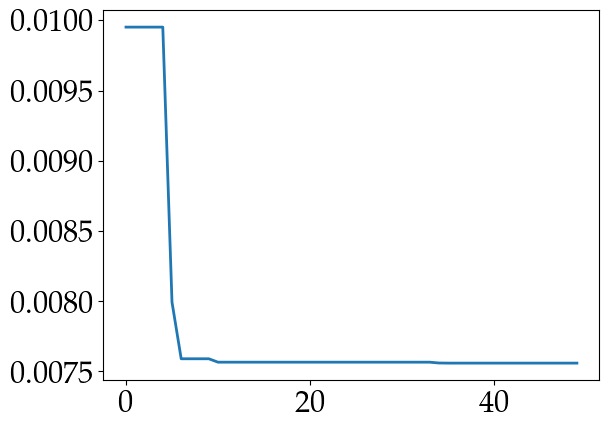

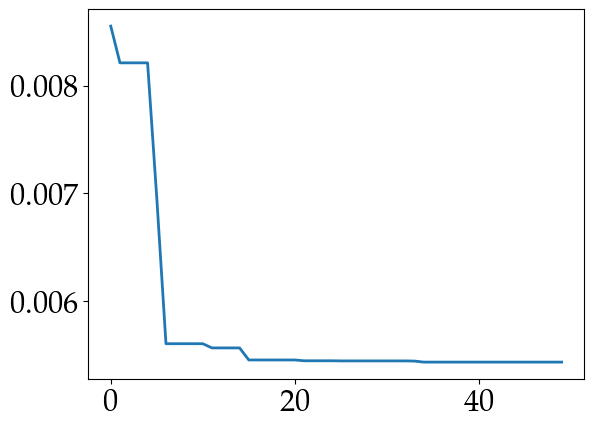

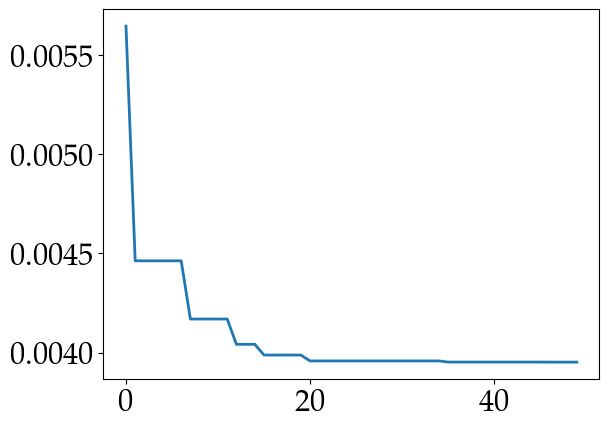

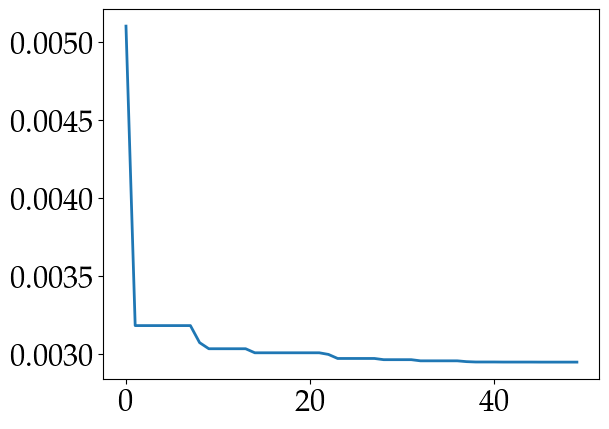

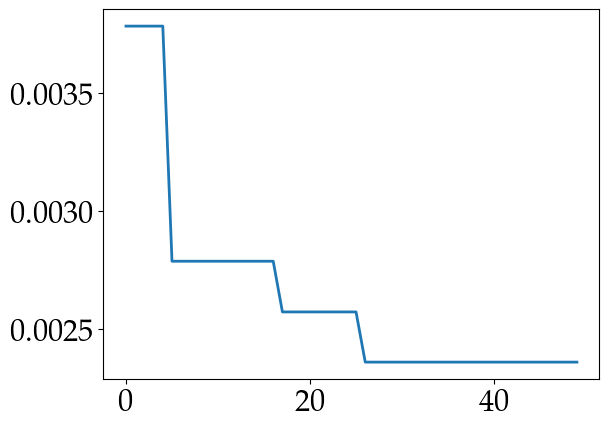

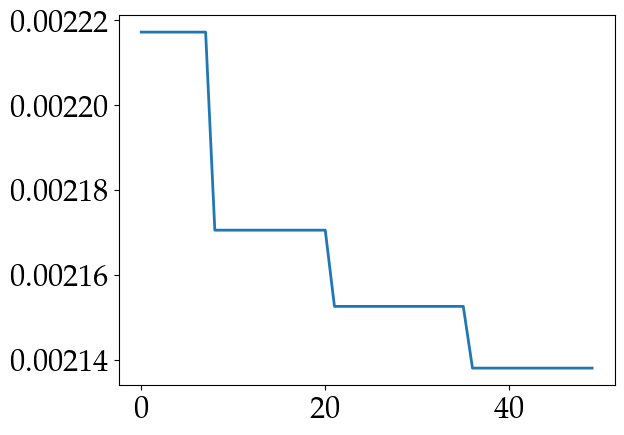

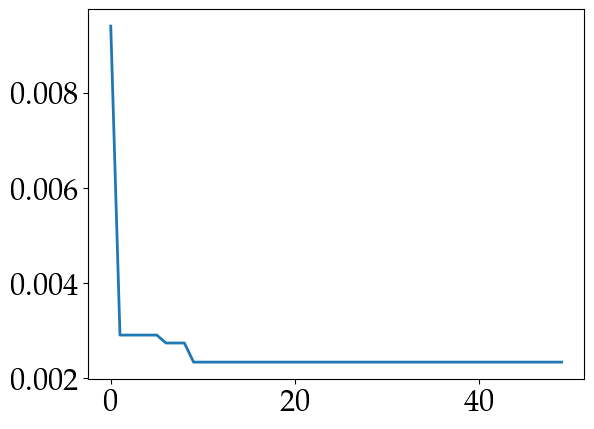

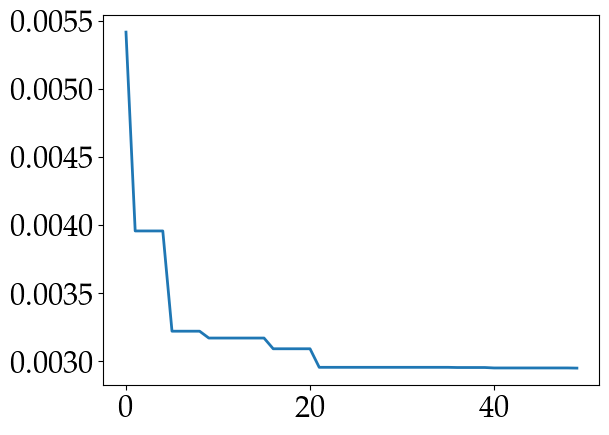

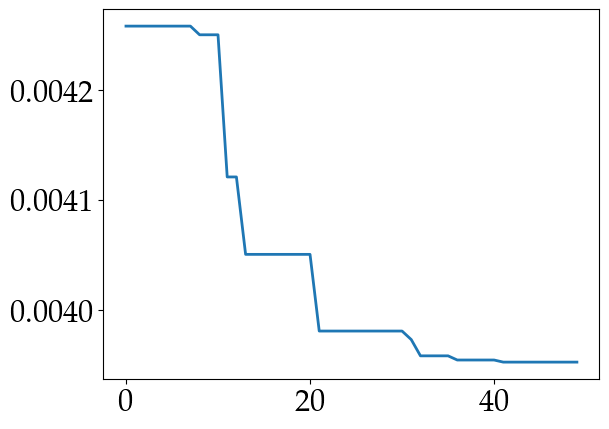

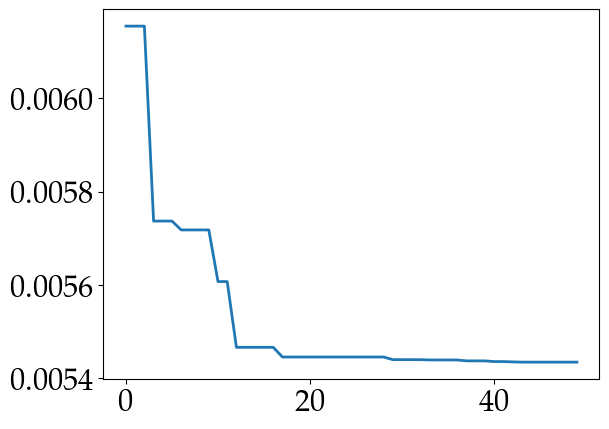

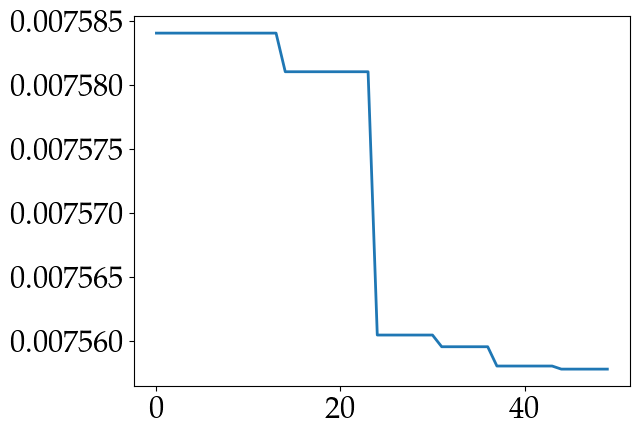

In [7]:
for i, cost_history in enumerate(all_cost_histories):
    plt.plot(cost_history, linewidth=2, label=f"Sensor {i+1}")
    plt.show()

In [9]:
op_l[:,0]

array([0.00732826, 0.00515216, 0.00365073, 0.00268484, 0.00219601,
       0.00221008, 0.00277211, 0.00371149, 0.00516905, 0.00732311])

In [11]:
op_l[:,1]

array([0.730044  , 1.18108944, 1.3487879 , 0.98311458, 5.11060051,
       3.24919846, 3.04904073, 4.25306979, 3.95202274, 3.88771329])